<a href="https://colab.research.google.com/github/arielbakal/vehicle_routing_problem/blob/main/vehicle_routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import numpy as np
import matplotlib.pyplot as plt

In [64]:
def generate_locations(depot_coord, locations_quantity, map_limit):

  x_components = np.random.randint(map_limit[0], map_limit[1], size=locations_quantity)
  y_components = np.random.randint(map_limit[0], map_limit[1], size=locations_quantity)
  locations = [np.array([x, y]) for x, y in zip(x_components, y_components)]

  return locations

Generating a list of $(x,y)$ random points

In [65]:
def routing( depot_coord, locations ):

  locations_local = locations[:]
  location_from = depot_coord
  routes = []

  while len(locations_local) != 0:
    location_index = np.argmin( [np.linalg.norm( location_from - location ) for location in locations_local] )
    location_to = locations_local[ location_index ]
    routes.append([location_from,location_to])
    location_from = location_to
    locations_local.pop(location_index)

  routes = routes + [ [routes[-1][1] , depot_coord] ]

  return routes

  Then i start tracing routes between the start point and its closest point, then the next closest point and so on, until it ends out of points and ends at the starting point

In [66]:
def map_routes(routes):

  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  x_coords = [point[0] for route in routes for point in route]
  y_coords = [point[1] for route in routes for point in route]

  for route in routes:
      axs[1].arrow(route[0][0], route[0][1], route[1][0] - route[0][0], route[1][1] - route[0][1], color='gray', width=0.025, length_includes_head=True, head_width=1.5)
      axs[1].plot([route[0][0], route[1][0]], [route[0][1], route[1][1]], color='gray')

  axs[1].scatter(x_coords[:-2], y_coords[:-2], label='Locations')
  axs[1].scatter(x_coords[-2:][1], y_coords[-2:][1], label='Depot')
  axs[1].set_xlabel('X')
  axs[1].set_ylabel('Y')
  axs[1].set_title('Routes')

  axs[0].scatter(x_coords[:-2], y_coords[:-2], label='Locations')
  axs[0].scatter(x_coords[-2:][1], y_coords[-2:][1], label='Depot')
  axs[0].set_xlabel('X')
  axs[0].set_ylabel('Y')
  axs[0].set_title('Map')

  plt.tight_layout()
  plt.legend()
  plt.show()

At first, i plot a Map with all the points and then the Routes Map

In [67]:
def run_algorithm( depot_coord, locations_quantity, map_limit ):

  locations_local = generate_locations( depot_coord, locations_quantity, map_limit )
  routes = routing( depot_coord, locations_local )
  map_routes(routes)

Lastly, i need a function whichs runs the whole algorithm

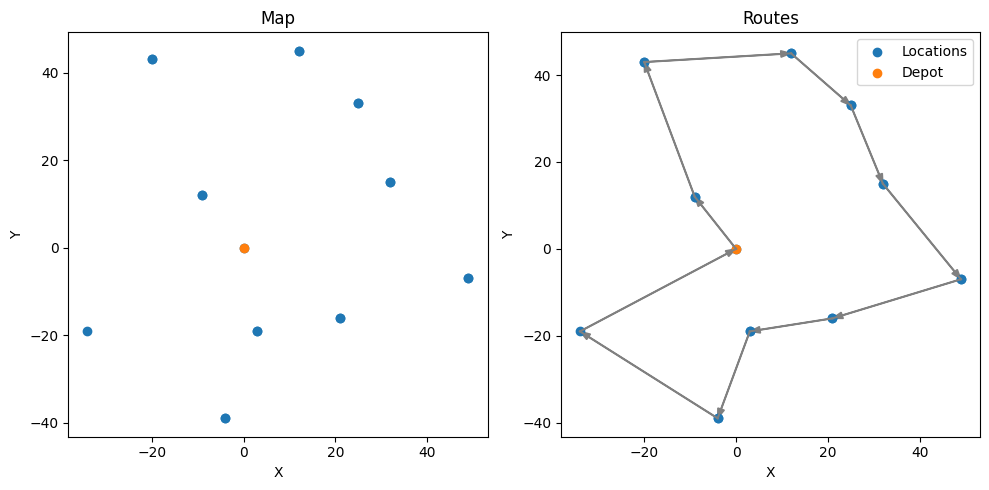

In [68]:
run_algorithm( (0,0), 10, (-50,50) )